## This code generates the electrode subset used in the Neuroprobe Lite benchmark.

NOTE: You do not need to run this notebook. The results are already saved in the `neuroprobe/config.py` file, in the variable NEUROPROBE_LITE_ELECTRODES. This file is provided for review of the code used to generate the subsets.

The idea behind this subset selection is to preserve as many full probes / continuous parts of probes as possible, to allow the most flexibility for various types of preprocessing, like Laplacian re-referencing, that depend on the neighbor data.

### Step 1. Load all of the single electrode results

In [8]:
from neuroprobe.config import *
from neuroprobe.braintreebank_subject import Subject as BraintreebankSubject
import numpy as np
import json

### LOADING ALL SINGLE ELECTRODE RESULTS ###

all_subjects = {
    subject_id: BraintreebankSubject(subject_id, cache=False)
    for subject_id, _ in NEUROPROBE_FULL_SUBJECT_TRIALS
}

print_warning = False
metric = "test_roc_auc" # "test_accuracy" or "test_roc_auc"
n_folds = 5
subject_trial_electrode_results = {}
total_electrode_task_n = 0
missed_electrode_task_n = 0
for (subject_id, trial_id) in NEUROPROBE_FULL_SUBJECT_TRIALS:
    subject = all_subjects[subject_id]
    electrode_labels = subject.electrode_labels


    if subject_id not in subject_trial_electrode_results:
        subject_trial_electrode_results[subject_id] = {}
    for task_i, task in enumerate(NEUROPROBE_TASKS):
        filename = f"data/eval_results_full_SS_SM/linear_voltage_single_electrode/electrode_btbank{subject_id}_{trial_id}_{task}.json"
        if not os.path.exists(filename):
            if print_warning:
                print(f"WARNING: File {filename} does not exist")
            continue
        with open(filename, "r") as f:
            data = json.load(f)['evaluation_results'][f'btbank{subject_id}_{trial_id}']

        n_timebins = len(next(iter(data['electrode'].values()))['time_bins'])
        
        if trial_id not in subject_trial_electrode_results[subject_id]:
            subject_trial_electrode_results[subject_id][trial_id] = np.zeros((len(electrode_labels), n_timebins, len(NEUROPROBE_TASKS), n_folds))
            subject_trial_electrode_results[subject_id][trial_id].fill(np.nan)
        
        for electrode_i, electrode_label in enumerate(electrode_labels):
            total_electrode_task_n += 1
            if electrode_label not in data['electrode']:
                if print_warning:
                    print(f"WARNING: Electrode {electrode_label} not found in {filename}")
                missed_electrode_task_n += 1
                continue
            
            for timebin_i, timebin in enumerate(range(n_timebins)):
                for fold_i, fold in enumerate(range(n_folds)):
                    subject_trial_electrode_results[subject_id][trial_id][electrode_i, timebin_i, task_i, fold_i] = data['electrode'][electrode_label]['time_bins'][timebin_i]['folds'][fold_i][metric]

print(f"Out of total {total_electrode_task_n} electrode-task pairs, {missed_electrode_task_n} electrode-task pairs were not found in the evaluation results ({missed_electrode_task_n/total_electrode_task_n*100:.2f}%).")

### EXTRACTING TIME BINS ###

time_bin_results_random_electrode = data['electrode'][next(iter(data['electrode'].keys()))]['time_bins']
bin_starts = np.array([time_bin['time_bin_start'] for time_bin in time_bin_results_random_electrode])
bin_ends = np.array([time_bin['time_bin_end'] for time_bin in time_bin_results_random_electrode])

### AVERAGING ACROSS ALL TRIALS AND FOLDS ###

print("Grand total average performance (across electrodes, time, tasks, folds):")
for subject_id, trial_id in NEUROPROBE_FULL_SUBJECT_TRIALS:
    print(f"\tbtbank{subject_id}_{trial_id}: {np.nanmean(subject_trial_electrode_results[subject_id][trial_id][np.newaxis, :, :, :, :]):.3f} ± {np.nanstd(subject_trial_electrode_results[subject_id][trial_id][np.newaxis, :, :, :, :]):.3f}")

subject_electrode_results = {
    subject_id: np.nanmean(np.nanmean(
        np.concatenate(
            [subject_trial_electrode_results[subject_id][trial_id][np.newaxis, :, :, :, :] for trial_id in subject_trial_electrode_results[subject_id]]
        ), axis=0), axis=-1)
     for subject_id in subject_trial_electrode_results
}

print("subject_electrode_results[1].shape", subject_electrode_results[1].shape)

### Getting average performance across all tasks and timebins for a given subject electrode ###

subject_electrode_neuroprobe_mean_performance = {
    subject_id: {
        electrode_label: np.nanmean(np.nanmean(subject_electrode_results[subject_id][electrode_id], axis=-1), axis=-1) for electrode_id, electrode_label in enumerate(all_subjects[subject_id].electrode_labels)
    } for subject_id in all_subjects
}

# Print mean performance for each subject and electrode
for subject_id, electrode_dict in subject_electrode_neuroprobe_mean_performance.items():
    performances = list(electrode_dict.values())
    mean_perf = np.mean(performances)
    std_perf = np.std(performances)
    print(f"Subject btbank{subject_id} mean performance (electrodes: {len(performances)}): {mean_perf:.3f} ± {std_perf:.3f}")



Out of total 75487 electrode-task pairs, 4690 electrode-task pairs were not found in the evaluation results (6.21%).
Grand total average performance (across electrodes, time, tasks, folds):
	btbank1_0: 0.505 ± 0.027
	btbank1_1: 0.505 ± 0.024
	btbank1_2: 0.505 ± 0.025
	btbank2_0: 0.507 ± 0.027
	btbank2_1: 0.508 ± 0.027
	btbank2_2: 0.505 ± 0.026
	btbank2_3: 0.507 ± 0.028
	btbank2_4: 0.507 ± 0.028
	btbank2_5: 0.509 ± 0.034
	btbank2_6: 0.503 ± 0.030
	btbank3_0: 0.505 ± 0.028
	btbank3_1: 0.510 ± 0.035
	btbank3_2: 0.511 ± 0.034
	btbank4_0: 0.504 ± 0.033
	btbank4_1: 0.502 ± 0.025
	btbank4_2: 0.499 ± 0.037
	btbank5_0: 0.502 ± 0.026
	btbank6_0: 0.501 ± 0.033
	btbank6_1: 0.502 ± 0.028
	btbank6_4: 0.501 ± 0.044
	btbank7_0: 0.504 ± 0.027
	btbank7_1: 0.504 ± 0.026
	btbank8_0: 0.503 ± 0.034
	btbank9_0: 0.500 ± 0.025
	btbank10_0: 0.501 ± 0.032
	btbank10_1: 0.503 ± 0.027
subject_electrode_results[1].shape (129, 14, 19)
Subject btbank1 mean performance (electrodes: 129): 0.505 ± 0.004
Subject btbank2 m

/tmp/ipykernel_3282455/870372869.py:68: RuntimeWarning: Mean of empty slice
  subject_id: np.nanmean(np.nanmean(


In [10]:
BRAINTREEBANK_SUBJECT_TRIAL_MOVIE_NAME_MAPPING = {
    "btbank1_0": "fantastic-mr-fox",
    "btbank1_1": "the-martian",
    "btbank1_2": "thor-ragnarok",
    "btbank2_0": "venom",
    "btbank2_1": "spider-man-3-homecoming",
    "btbank2_2": "guardians-of-the-galaxy",
    "btbank2_3": "guardians-of-the-galaxy-2",
    "btbank2_4": "avengers-infinity-war",
    "btbank2_5": "black-panther",
    "btbank2_6": "aquaman",
    "btbank3_0": "cars-2",
    "btbank3_1": "lotr-1",
    "btbank3_2": "lotr-2",
    "btbank4_0": "shrek-the-third",
    "btbank4_1": "megamind",
    "btbank4_2": "incredibles",
    "btbank5_0": "fantastic-mr-fox",
    "btbank6_0": "megamind",
    "btbank6_1": "toy-story",
    "btbank6_4": "coraline",
    "btbank7_0": "cars-2",
    "btbank7_1": "megamind",
    "btbank8_0": "sesame-street-episode-3990",
    "btbank9_0": "ant-man",
    "btbank10_0": "cars-2",
    "btbank10_1": "spider-man-far-from-home"
}

NEUROPROBE_NANO_SUBJECT_TRIALS = [
    (1, 1), 
    (2, 4),
    (3, 1),
    (4, 0),
    (7, 1),
    (10, 1)
]

In [17]:
NEUROPROBE_LITE_N_ELECTRODES = 120
NEUROPROBE_NANO_N_ELECTRODES = 30

def stem_electrode_name(name):
    #names look like 'O1aIb4', 'O1aIb5', 'O1aIb6', 'O1aIb7'
    #names look like 'T1b2
    found_stem_end = False
    stem, num = [], []
    for c in reversed(name):
        if c.isalpha():
            found_stem_end = True
        if found_stem_end:
            stem.append(c)
        else:
            num.append(c)
    return ''.join(reversed(stem)), int(''.join(reversed(num)))
def find_streaks(nums):
    if not nums:
        return []
    nums = sorted(nums)
    streaks = []
    current_streak = [nums[0]]
    
    for i in range(1, len(nums)):
        if nums[i] == nums[i-1] + 1:
            current_streak.append(nums[i])
        else:
            if len(current_streak) > 0:
                streaks.append(current_streak)
            current_streak = [nums[i]]
            
    streaks.append(current_streak)
    return streaks

electrode_subsets_lite = {}
electrode_subsets_nano = {}
for subject_id in range(1, 11):
    print("\n\n\n", "=== Generating electrode subsets for subject", subject_id)

    subject = all_subjects[subject_id]
    electrode_labels = subject.electrode_labels

    stem_nums = [stem_electrode_name(e) for e in electrode_labels]
    stems = [x[0] for x in stem_nums]
    nums = [x[1] for x in stem_nums]

    probes = {
        stem: [num for (s, num) in stem_nums if s == stem]
        for stem in set(stems)
    }
    print("\tFound", len(probes), "probes:")
    print("\t", probes)

    # Find longest streak for each probe
    probe_streaks = {}
    for probe, nums in probes.items():
        streaks = find_streaks(nums)
        # Sort streaks by length (descending) and take all streaks
        probe_streaks[probe] = sorted(streaks, key=len, reverse=True)
    # Create list of all streaks with their probe names
    all_streaks = []
    for probe, streaks in probe_streaks.items():
        for streak in streaks:
            all_streaks.append((probe, streak))
    # Sort by streak length in descending order
    # Calculate mean performance for each streak
    streak_performances = []
    for probe, streak in all_streaks:
        performances = []
        for num in streak:
            if f"{probe}{num}" in subject_electrode_neuroprobe_mean_performance[subject_id]:
                performances.append(subject_electrode_neuroprobe_mean_performance[subject_id][f"{probe}{num}"])
        streak_performances.append((probe, streak, np.nanmean(performances)))
    
    # Sort by mean performance in descending order
    streak_performances.sort(key=lambda x: x[2], reverse=True)
    print("\tAll streaks sorted by performance (descending):")
    for probe, streak, mean_perf in streak_performances:
        performances = []
        for num in streak:
            if f"{probe}{num}" in subject_electrode_neuroprobe_mean_performance[subject_id]:
                performances.append(subject_electrode_neuroprobe_mean_performance[subject_id][f"{probe}{num}"])
        print(f"\t\t{probe}: {streak} (length: {len(streak)}, mean: {np.nanmean(performances):.3f} +- {np.nanstd(performances):.3f})")
    all_streaks = [x[:2] for x in streak_performances]

    def select_electrodes(n_electrodes):
        # Initialize variables to track selected electrodes
        selected_electrodes = []
        total_electrodes = 0

        # Iterate through streaks in descending order of length
        for probe, streak in all_streaks:
            # if this is a streak of 1 electrode, skip it
            if len(streak) == 1:
                continue
        
            # Add all electrodes from this streak until we reach our target
            for num in streak:
                selected_electrodes.append(f"{probe}{num}")
                total_electrodes += 1
                if total_electrodes == n_electrodes:
                    break
            
            # Break if we've reached our target OR if there is only one electrode left
            if total_electrodes >= n_electrodes-1:
                break
        return selected_electrodes

    electrode_subsets_lite[subject.subject_identifier] = select_electrodes(NEUROPROBE_LITE_N_ELECTRODES)
    print(f"\tSelected {len(electrode_subsets_lite[subject.subject_identifier])} electrodes for subject {subject.subject_identifier} (Lite):")
    print("\t\t", electrode_subsets_lite[subject.subject_identifier])

    electrode_subsets_nano[subject.subject_identifier] = select_electrodes(NEUROPROBE_NANO_N_ELECTRODES)
    print(f"\tSelected {len(electrode_subsets_nano[subject.subject_identifier])} electrodes for subject {subject.subject_identifier} (Nano):")
    print(f"\t\t", electrode_subsets_nano[subject.subject_identifier])





 === Generating electrode subsets for subject 1
	Found 13 probes:
	 {'T3bOT': [1, 2, 3, 4, 5, 6, 8, 9, 10, 12], 'T1bIc': [1, 2, 3, 4, 5, 6, 7, 8], 'T1cIf': [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16], 'F3cId': [1, 2, 3, 4, 5, 6, 7, 8, 9], 'T3aHb': [6, 9, 10, 12], 'F3bIaOFb': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], 'F3dIe': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 14], 'T2d': [1, 2, 3, 4, 5, 6], 'F3aOFa': [2, 3, 4, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], 'T1aIb': [1, 2, 3, 4, 5, 6, 7, 8], 'T2bHa': [1, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14], 'T2c': [4, 5, 6, 7, 8], 'T2aA': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}
	All streaks sorted by performance (descending):
		T1bIc: [1, 2, 3, 4, 5, 6, 7, 8] (length: 8, mean: 0.514 +- 0.006)
		T1cIf: [10, 11, 12, 13, 14, 15, 16] (length: 7, mean: 0.512 +- 0.004)
		T3aHb: [12] (length: 1, mean: 0.510 +- 0.000)
		T1aIb: [1, 2, 3, 4, 5, 6, 7, 8] (length: 8, mean: 0.507 +- 0.002)
		T3aHb: [9, 10] (length: 2, mean: 0.507 +- 0.001)
		T3aHb:

In [18]:
import json
print("NEUROPROBE_LITE_ELECTRODES =", json.dumps(electrode_subsets_lite))
print("NEUROPROBE_NANO_ELECTRODES =", json.dumps(electrode_subsets_nano))


NEUROPROBE_LITE_ELECTRODES = {"btbank1": ["T1bIc1", "T1bIc2", "T1bIc3", "T1bIc4", "T1bIc5", "T1bIc6", "T1bIc7", "T1bIc8", "T1cIf10", "T1cIf11", "T1cIf12", "T1cIf13", "T1cIf14", "T1cIf15", "T1cIf16", "T1aIb1", "T1aIb2", "T1aIb3", "T1aIb4", "T1aIb5", "T1aIb6", "T1aIb7", "T1aIb8", "T3aHb9", "T3aHb10", "T1cIf1", "T1cIf2", "T1cIf3", "T1cIf4", "T1cIf5", "T1cIf6", "T1cIf7", "T1cIf8", "T2bHa7", "T2bHa8", "T2bHa9", "T2bHa10", "T2bHa11", "T2bHa12", "T2bHa13", "T2bHa14", "T3bOT8", "T3bOT9", "T3bOT10", "F3cId1", "F3cId2", "F3cId3", "F3cId4", "F3cId5", "F3cId6", "F3cId7", "F3cId8", "F3cId9", "T2c4", "T2c5", "T2c6", "T2c7", "T2c8", "F3bIaOFb1", "F3bIaOFb2", "F3bIaOFb3", "F3bIaOFb4", "F3bIaOFb5", "F3bIaOFb6", "F3bIaOFb7", "F3bIaOFb8", "F3bIaOFb9", "F3bIaOFb10", "F3bIaOFb11", "F3bIaOFb12", "F3bIaOFb13", "F3bIaOFb14", "F3bIaOFb15", "F3bIaOFb16", "T2d1", "T2d2", "T2d3", "T2d4", "T2d5", "T2d6", "F3aOFa7", "F3aOFa8", "F3aOFa9", "F3aOFa10", "F3aOFa11", "F3aOFa12", "F3aOFa13", "F3aOFa14", "F3aOFa15", "F3aOF

/tmp/ipykernel_1698186/3867202268.py:2: RuntimeWarning: Mean of empty slice
  task_performances = [np.nanmean(subject_electrode_results[subject_id], axis=0) for subject_id in subject_electrode_results]


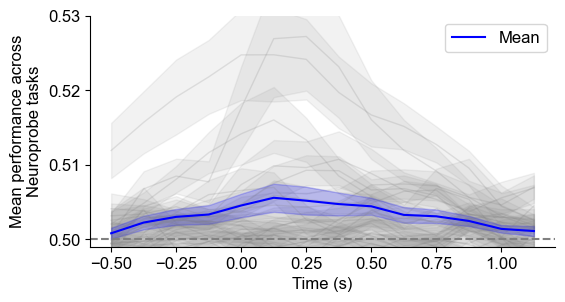

In [38]:
# Get individual task performances (averaged across electrodes)
task_performances = [np.nanmean(subject_electrode_results[subject_id], axis=0) for subject_id in subject_electrode_results]
task_performances = np.array(task_performances) # Shape: (subjects, time, tasks)

# Calculate mean and std across subjects for each task
means = np.nanmean(task_performances, axis=0) # Shape: (time, tasks) 
stds = np.nanstd(task_performances, axis=0) / np.sqrt(task_performances.shape[0]) # Shape: (time, tasks)

import matplotlib.pyplot as plt
# Add Arial font
import matplotlib.font_manager as fm
font_path = 'assets/font_arial.ttf'
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams.update({'font.size': 12})

plt.figure(figsize=(6, 3))

# Plot individual task lines with error bars
for task_i in range(means.shape[1]):
    plt.plot(bin_starts, means[:, task_i], color='gray', alpha=0.2, linewidth=1)
    plt.fill_between(bin_starts, 
                    means[:, task_i] - stds[:, task_i],
                    means[:, task_i] + stds[:, task_i],
                    color='gray', alpha=0.1)

# Plot mean and std across all tasks
overall_mean = np.nanmean(means, axis=1) # Shape: (time,)
overall_std = np.nanstd(means, axis=1) / np.sqrt(means.shape[1]) # Shape: (time,)
plt.plot(bin_starts, overall_mean, label='Mean', color='blue')
plt.fill_between(bin_starts, overall_mean - overall_std, overall_mean + overall_std, alpha=0.2, color='blue')

plt.axhline(y=0.5, color='gray', linestyle='--')
plt.ylim(0.499, 0.53)
plt.yticks([0.5, 0.51, 0.52, 0.53])
plt.xticks(bin_starts[::2])
plt.xlabel("Time (s)")
plt.ylabel("Mean performance across\nNeuroprobe tasks")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend()
plt.show()

In [41]:
bin_starts

array([-0.5  , -0.375, -0.25 , -0.125,  0.   ,  0.125,  0.25 ,  0.375,
        0.5  ,  0.625,  0.75 ,  0.875,  1.   ,  1.125])

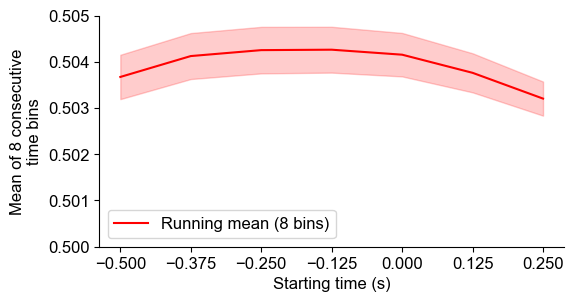

In [51]:
# Calculate running mean and SEM over consecutive bins
n_consecutive_bins = 8  # Can adjust this parameter
running_mean = np.zeros(len(overall_mean) - n_consecutive_bins + 1)
running_sem = np.zeros(len(overall_mean) - n_consecutive_bins + 1)

for i in range(len(running_mean)):
    running_mean[i] = np.mean(overall_mean[i:i+n_consecutive_bins])
    running_sem[i] = overall_std[i:i+n_consecutive_bins].mean() / np.sqrt(n_consecutive_bins)

plt.figure(figsize=(6, 3))
plt.plot(bin_starts[:-n_consecutive_bins+1], running_mean, color='red', 
         label=f'Running mean ({n_consecutive_bins} bins)')
plt.fill_between(bin_starts[:-n_consecutive_bins+1], 
                 running_mean - running_sem,
                 running_mean + running_sem,
                 alpha=0.2, color='red')
plt.xlabel("Starting time (s)")
plt.ylabel(f"Mean of {n_consecutive_bins} consecutive\ntime bins")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.ylim(0.5, 0.505)
plt.legend()
plt.xticks(bin_starts[:-n_consecutive_bins+1])
plt.show()
